# **Statistics(I)(2) - Final Project Code**
## **Task 1**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import statsmodels.stats.api as sms
from scipy import stats
import seaborn as sns
import math

In [2]:
def f_test_variances(x1, x2, sides, alpha):
    a1 = np.array(x1)
    a2 = np.array(x2)

    result = np.full((7, 2), None, dtype=float)
    
    result[0] = [np.mean(a1), np.mean(a2)]                    # Means
    result[1] = [np.std(a1, ddof=1), np.std(a2, ddof=1)]      # Sample standard deviations
    result[2] = [a1.size, a2.size]                            # Sample sizes

    dfn, dfd = a1.size - 1, a2.size - 1
    result[3] = [dfn, dfd]

    # F-statistic: ratio of sample variances
    f_stat = np.var(a1, ddof=1) / np.var(a2, ddof=1)
    result[4, 0] = f_stat

    # Critical F-values
    if sides > 1:
        result[5] = [
            stats.f.isf(alpha / 2, dfn, dfd),  # Upper critical value
            stats.f.ppf(alpha / 2, dfn, dfd)   # Lower critical value
        ]
    else:
        result[5] = [
            stats.f.isf(alpha, dfn, dfd),      # One-sided critical value
            stats.f.ppf(alpha, dfn, dfd)
        ]

    if f_stat > 1:
        p_value = 1 - stats.f.cdf(f_stat, dfn, dfd)
    else:
        p_value = stats.f.cdf(f_stat, dfn, dfd)
    if sides > 1:
        p_value *= 2
    result[6, 0] = p_value

    labels = ['Mean', 'Std Dev', 'Size', 'Degrees of Freedom', 'F-statistic', 'F-critical', 'p-value']
    df = pd.DataFrame(result, index=labels)

    return df

In [6]:
def t_test_summary(x1, x2, usevar='pooled', alpha=0.05):
    """
    Runs a t-test using statsmodels' CompareMeans and prints a summary.

    Parameters:
    - df: DataFrame containing the columns
    - col1, col2: Column names to compare
    - usevar: 'pooled' (equal variances) or 'unequal' (Welch)
    - alpha: Significance level
    """
    group1 = sms.DescrStatsW(x1)
    group2 = sms.DescrStatsW(x2)
    t_test = sms.CompareMeans(group1, group2)
    
    return t_test.summary(usevar=usevar, alpha=alpha)

In [13]:
def chi_square_normality_test(data, bins=8):
    counts, edges = np.histogram(data, bins=bins)
    mu, sigma = np.mean(data), np.std(data)
    expected_probs = stats.norm.cdf(edges[1:], mu, sigma) - stats.norm.cdf(edges[:-1], mu, sigma)
    expected_counts = expected_probs * len(data)
    expected_counts *= counts.sum() / expected_counts.sum()
    # 卡方檢定
    stat, p = stats.chisquare(f_obs=counts, f_exp=expected_counts)
    return stat, p

In [41]:
df = pd.read_csv("movie_summary.csv")

filtered_df = df[
    (df['production_budget'] != 0) &
    (df['production_year'] > 2000) &
    df['genre'].notna() &
    df['domestic_box_office'].notna() &
    df['international_box_office'].notna()
].copy()
filtered_df["total_box_office"] = filtered_df["domestic_box_office"] + filtered_df["international_box_office"]
# 現在適用log壓，可以換看看
filtered_df["flattened_production_budget"] = np.log1p(filtered_df["production_budget"])
filtered_df["flattened_total_box_office"] = np.log1p(filtered_df["total_box_office"])

filtered_df['z_score'] = stats.zscore(filtered_df['flattened_total_box_office'])
filtered_df = filtered_df[filtered_df['z_score'].abs() <= 3].copy()

# 預算分4組，每組1000萬
bin_edges = [0, 10_000_000, 20_000_000, 30_000_000, 40_000_000]
bin_labels = ['0_1000w', '1000_2000w', '2000_3000w', '3000_4000w']
filtered_df['budget_group'] = pd.cut(
    filtered_df['production_budget'],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
)

# 分四組完整的 DataFrame
grouped_df = {
    label: filtered_df[filtered_df['budget_group'] == label].copy()
    for label in bin_labels
}

group_shapes = {label: df.shape for label, df in grouped_df.items()}
group_shapes



{'0_1000w': (1135, 28),
 '1000_2000w': (689, 28),
 '2000_3000w': (456, 28),
 '3000_4000w': (327, 28)}

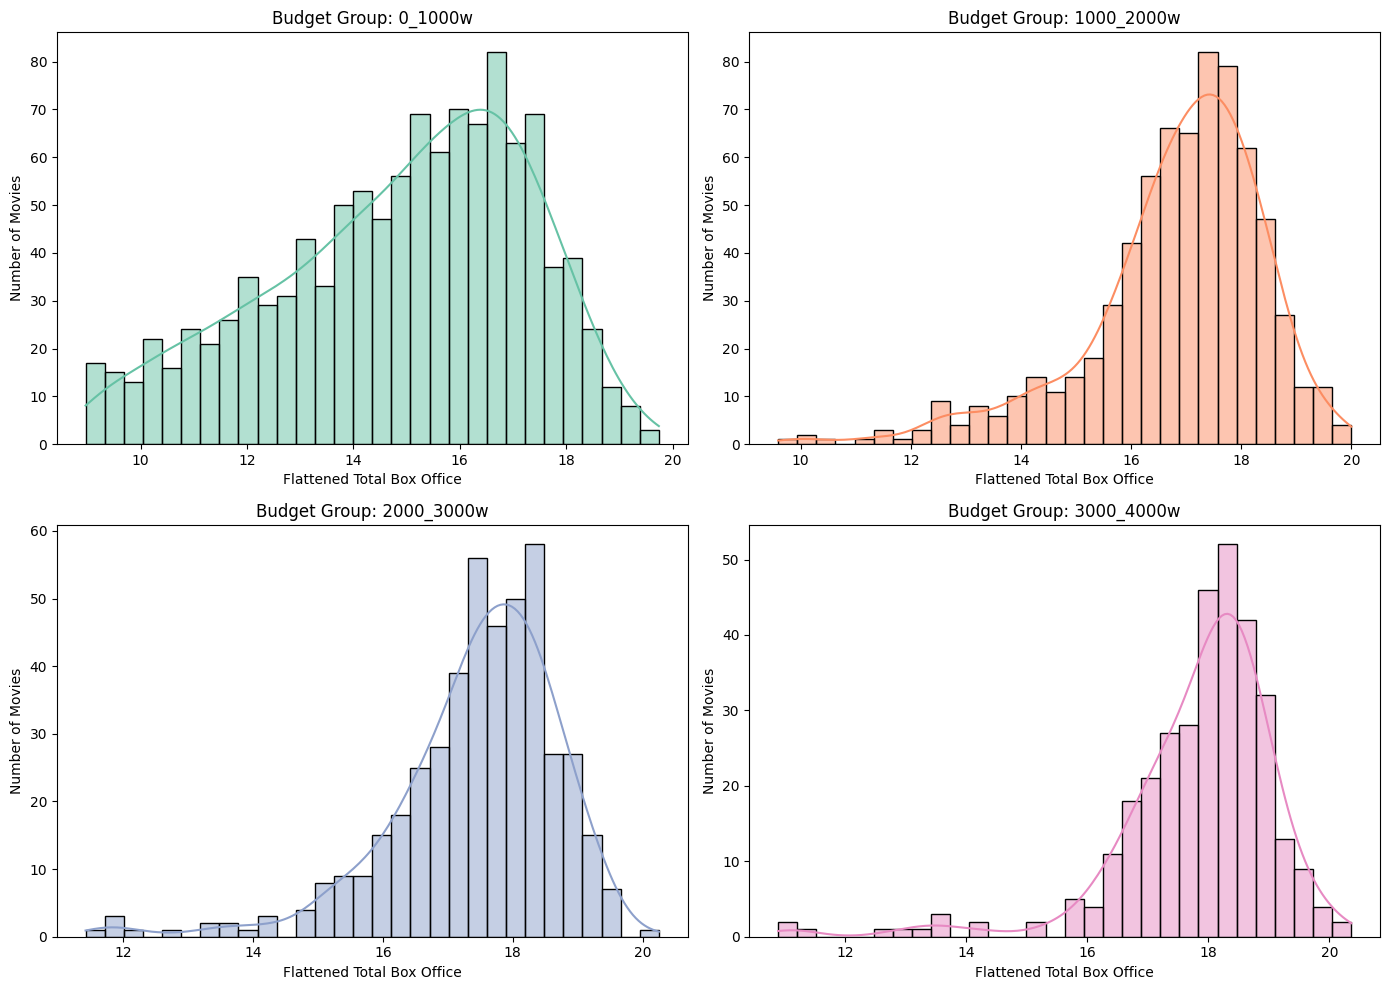

In [ ]:
# 畫每個組別的票房分布
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, label in enumerate(['0_1000w', '1000_2000w', '2000_3000w', '3000_4000w']):
    sns.histplot(
        data=grouped_df[label],
        x='flattened_total_box_office',
        bins=30,
        kde=True,
        ax=axes[i],
        color=sns.color_palette("Set2")[i]
    )
    axes[i].set_title(f"Budget Group: {label}")
    axes[i].set_xlabel("Flattened Total Box Office")
    axes[i].set_ylabel("Number of Movies")

plt.tight_layout()
plt.show()

In [40]:
# 執行常態檢定
for label, df_group in grouped_df.items():
    x = df_group["flattened_total_box_office"]

    # Shapiro-Wilk test
    s_stat, s_p = stats.shapiro(x)

    # Chi-square test
    try:
        c_stat, c_p = chi_square_normality_test(x)
        chi_msg = f"χ² = {c_stat:.4f}, p = {c_p:.4f} → {'常態' if c_p > 0.05 else '不常態'}"
    except ValueError as e:
        chi_msg = f"Chi-square 檢定失敗：{e}"

    print(f"\n預算組別：{label}")
    print(f"Shapiro-Wilk  : W = {s_stat:.4f}, p = {s_p:.4f} → {'常態' if s_p > 0.05 else '不常態'}")
    print(f"Chi-square    : {chi_msg}")


預算組別：0_1000w
Shapiro-Wilk  : W = 0.9648, p = 0.0000 → 不常態
Chi-square    : χ² = 112.3155, p = 0.0000 → 不常態

預算組別：1000_2000w
Shapiro-Wilk  : W = 0.9208, p = 0.0000 → 不常態
Chi-square    : χ² = 302.6061, p = 0.0000 → 不常態

預算組別：2000_3000w
Shapiro-Wilk  : W = 0.9090, p = 0.0000 → 不常態
Chi-square    : χ² = 802.2689, p = 0.0000 → 不常態

預算組別：3000_4000w
Shapiro-Wilk  : W = 0.8401, p = 0.0000 → 不常態
Chi-square    : χ² = 5758.0122, p = 0.0000 → 不常態


In [76]:
f_test_variances(budget_low, budget_high, sides=2, alpha=0.05)

,0,1
Mean,6.873283e+00,9.823617
Std Dev,2.046081e+00,1.699519
Size,1.520000e+03,2184.000000
Degrees of Freedom,1.519000e+03,2183.000000
F-statistic,1.449417e+00,NaN
F-critical,1.096643e+00,0.911162
p-value,2.442491e-15,NaN


In [77]:
t_test_summary(budget_low, budget_high, usevar='unequal', alpha=0.05)

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,-2.9503,0.064,-46.208,0.000,-3.076,-2.825
